## Turn Kevin's txt file into ecsv and save in caldbinput

In [1]:
import os
from astropy.table import QTable
from astropy import units as u

from marxs.missions.arcus.utils import config

In [2]:
def convert_TAUS_to_ecsv(filename):
    Gxxx = QTable.read(f'../../caldb-inputdata/TAUS/{filename}',
                       format='ascii.no_header', data_start=2,
                       names=['wavelength', 'A_eff', 'delta_wave', 'ResolvingPower',
                             'DetectorBackground'],
                       units=[u.Angstrom, u.cm**2, u.Angstrom, None,
                              u.count/u.s],
                       delimiter=',')
    Gxxx.meta['ORIGFILE'] = filename
    Gxxx.meta['COMMENT'] = 'BKG is in usings of cts/s/resolution element'
    Gxxx.meta['Author'] = 'Kevin France'
    Gxxx.meta['origin'] = 'per email Friday, 2023-03-31'
    Gxxx.meta['conversion'] = 'converted to ecsv format by Moritz Guenther'
    return Gxxx

In [3]:
ls ../../caldb-inputdata/TAUS/

AUS_v2_cassegrain_G110M_performance_021423.txt
Arcus_FUV_Aeff_SNR_cass021423kf.ps
G110M.csv
G130L.csv
G140M.csv
TAUS_v1_stubby1_G110M_performance_012023.txt
TAUS_v1_stubby1_G140M_performance_012023.txt
TAUS_v2_cassegrain_G130L_performance_021423.txt
TAUS_v2_cassegrain_G140M_performance_021423.txt
TAUS_v3_cassegrain_60cm_G110M_performance_040123.txt


In [4]:
G110 = convert_TAUS_to_ecsv('TAUS_v3_cassegrain_60cm_G110M_performance_040123.txt')
G110.write(os.path.join(config['data']['caldb_inputdata'], 'TAUS',
                                  'G110M.csv'), format='ascii.ecsv', overwrite=True)

## Use file in caldb-input to make ARF and RMF for TAUS

In [5]:
import os
import numpy as np
from astropy.table import Table
import astropy.units as u
from scipy import interpolate
from marxs.reduction import ogip
from marxs.missions.arcus.utils import config

In [6]:
def tag_TAUS(tab, grating):
    tab.meta['SATELLIT'] = ('ARCUS', 'placeholder - no name registered with OGIP')
    tab.meta['TELESCOP'] = ('TAUS', 'placeholder - no name registered with OGIP')
    tab.meta['INSTRUME'] = (f'{grating}',  'placeholder - no name registered with OGIP')
    tab.meta['FILTER'] = ('NONE', 'filter information')

In [7]:
def mkarf_taus(grating, oversample=5):
    Gxxx = Table.read(os.path.join(config['data']['caldb_inputdata'], 'TAUS',
                                  f'{grating}.csv'), format='ascii.ecsv')
    in_range = Gxxx['A_eff'] > 0
    tab = Gxxx[in_range]
    # Implemented assuming constant width of a spectral resolution element
    if not np.allclose(tab['delta_wave'], tab['delta_wave'][0]):
        assert ValueError('Function assumes constant resolution element for all wavelength.')
    channel_edges = np.arange(np.min(tab['wavelength']),
                          # Get last element
                          np.max(tab['wavelength']) + tab['delta_wave'][0] / 2,
                          tab['delta_wave'][0] / oversample) * tab['wavelength'].unit
    energy_edges = channel_edges.to(u.keV, equivalencies=u.spectral())
    energy_edges = np.sort(energy_edges)
    en_mid = 0.5 * (energy_edges[:-1] + energy_edges[1:])

    #Aeff_interpolator = interp1d(tab['wavelength'], tab['A_eff'], kind='cubic',
    #                             fill_value='extrapolate')
    
    tck = interpolate.splrep(tab['wavelength'], tab['A_eff'], s=1000)

    arf = ogip.ARF(data=[energy_edges[:-1], 
                         energy_edges[1:],
                         interpolate.splev(en_mid.to(u.Angstrom, 
                                             equivalencies=u.spectral()).value, tck, der=0),
                         #Aeff_interpolator(en_mid.to(u.Angstrom, 
                         #                    equivalencies=u.spectral()).value),
                        energy_edges[1:].to(u.Angstrom,
                                        equivalencies=u.spectral()),
                        energy_edges[:-1].to(u.Angstrom,
                                         equivalencies=u.spectral()),
                    ],
              names=['ENERG_LO', 'ENERG_HI', 'SPECRESP',
                     # CIAO adds these to grating ARFs, so we do, too:
                     'BIN_LO', 'BIN_HI',
                     ])
    tag_TAUS(arf, grating)

    return arf, Gxxx, channel_edges

In [8]:
for grating in ['G110M']:
    arf, grattab, bin_edges = mkarf_taus(grating)
    arf.write(f'~/MITDropbox/ARCUS/{grating}.arf', overwrite=True)
    grattab.rename_column('wavelength', 'wave')
    # convert FWHM to sigma
    grattab['sigma_wave'] = grattab['delta_wave']  / (2 * np.sqrt(2 * np.log(2)))

    outrmf = ogip.RMF.from_Gauss_sigma(bin_edges.to(u.Angstrom, 
                                                    equivalencies=u.spectral()),
                                       grattab)
    tag_TAUS(outrmf.ebounds, grating=grating)
    tag_TAUS(outrmf.matrix, grating=grating)
    outrmf.write(f'/Users/guenther/MITDropbox/ARCUS/{grating}.rmf', overwrite=True)


In [9]:
from sherpa.astro.io import read_arf, read_rmf

In [10]:
arf = read_arf('/Users/guenther/MITDropbox/ARCUS/G110M.arf')
rmf = read_rmf('/Users/guenther/MITDropbox/ARCUS/G110M.rmf')

In [11]:
arf

<DataARF data set instance '/Users/guenther/MITDropbox/ARCUS/G110M.arf'>

In [12]:
rmf

<DataRMF data set instance '/Users/guenther/MITDropbox/ARCUS/G110M.rmf'>

In [13]:
from sherpa.astro import ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [14]:
ui.clean()

In [15]:

ui.set_source(1, ui.blackbody.bb + ui.gauss1d.g1)
# Need to have data before set_analysis takes effect
# So make, some data, then set set_analysis, 
# then set any useful parameters
ui.fake_pha(1, '/Users/guenther/MITDropbox/ARCUS/G110M.arf',
            '/Users/guenther/MITDropbox/ARCUS/G110M.rmf', 5000)
ui.set_analysis('wave')


In [16]:
g1.pos = 1100.5
g1.fwhm = 0.001
g1.ampl = 1

bb.temperature = 20000
bb.ampl = 0.00001

In [17]:
ui.fake_pha(1, '/Users/guenther/MITDropbox/ARCUS/G110M.arf',
            '/Users/guenther/MITDropbox/ARCUS/G110M.rmf', 5000)

(1100.3, 1100.8)

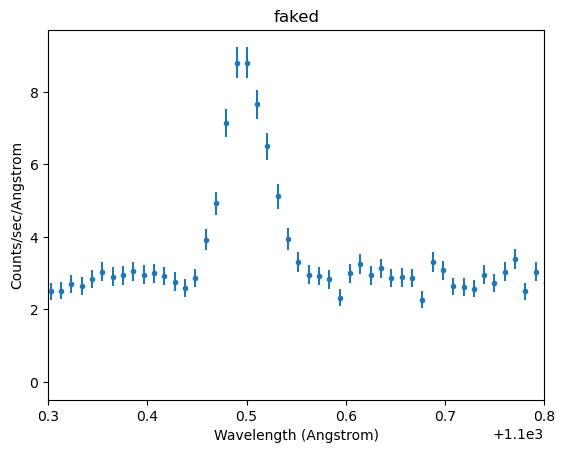

In [18]:
import matplotlib.pyplot as plt

ui.plot_data(1)
ax = plt.gca()
ax.set_xlim(1100.3, 1100.8)

In [19]:
ui.get_model()

<RSPModelPHA model instance 'apply_rmf(apply_arf((5000.0 * (blackbody.bb + gauss1d.g1))))'>

## Make PHA files for background simulations

TBD